# Aerosol Correction and Atmospheric Transmittance

This notebook covers two critical aspects of atmospheric correction:

1. **Aerosol Path Radiance** - Estimating and removing scattered light from atmospheric aerosols
2. **Atmospheric Transmittance** - Accounting for attenuation of light through the atmosphere

These are challenging components because aerosol properties vary spatially and temporally, and the algorithms must separate aerosol contributions from the desired water signal.

In [41]:
import numpy as np
import matplotlib.pyplot as plt

from correct_atmosphere import constants
from correct_atmosphere import aerosols
from correct_atmosphere import transmittance
from correct_atmosphere import rayleigh

---
## 1. Aerosol Models

The atmospheric correction uses pre-computed lookup tables based on **Ahmad et al. (2010)** aerosol models. There are multiple aerosol types at different relative humidity levels.

### Aerosol Types

The standard model set includes:
- Maritime aerosols (sea salt dominated)
- Coastal aerosols (mixed continental/maritime)
- Tropospheric aerosols (continental background)

Each type is computed at multiple relative humidity levels (30%, 50%, 70%, 80%, 90%, 95%, 98%, 99%).

In [42]:
# Create example aerosol models
model_maritime = aerosols.AerosolModel(
    model_id=1,
    fine_fraction=0.2,
    angstrom_exponent=0.2,  # Coarse particles (low Angstrom)
    effective_radius=1.5,
    relative_humidity=90.0
)

model_continental = aerosols.AerosolModel(
    model_id=7,
    fine_fraction=0.8,
    angstrom_exponent=1.5,  # Fine particles (high Angstrom)
    effective_radius=0.3,
    relative_humidity=70.0
)

print("Maritime Aerosol Model:")
print(f"  Model ID: {model_maritime.model_id}")
print(f"  Angstrom exponent: {model_maritime.angstrom_exponent}")
print(f"  Fine fraction: {model_maritime.fine_fraction}")
print(f"  Effective radius: {model_maritime.effective_radius} um")
print(f"  Relative humidity: {model_maritime.relative_humidity}%")

print("\nContinental Aerosol Model:")
print(f"  Model ID: {model_continental.model_id}")
print(f"  Angstrom exponent: {model_continental.angstrom_exponent}")
print(f"  Fine fraction: {model_continental.fine_fraction}")
print(f"  Effective radius: {model_continental.effective_radius} um")
print(f"  Relative humidity: {model_continental.relative_humidity}%")

Maritime Aerosol Model:
  Model ID: 1
  Angstrom exponent: 0.2
  Fine fraction: 0.2
  Effective radius: 1.5 um
  Relative humidity: 90.0%

Continental Aerosol Model:
  Model ID: 7
  Angstrom exponent: 1.5
  Fine fraction: 0.8
  Effective radius: 0.3 um
  Relative humidity: 70.0%


### Angstrom Exponent

The Angstrom exponent characterizes the spectral dependence of aerosol optical thickness:

$$\tau_a(\lambda) = \tau_a(\lambda_0) \left(\frac{\lambda}{\lambda_0}\right)^{-\alpha}$$

where $\alpha$ is the Angstrom exponent.

- **Low $\alpha$ (~0-0.5)**: Large (coarse) particles - sea salt, dust
- **High $\alpha$ (~1.5-2)**: Small (fine) particles - smoke, pollution

In [43]:
# Calculate Angstrom exponent from two wavelengths
wavelength1, wavelength2 = 443, 865  # nm
tau1, tau2 = 0.15, 0.08  # Example AOT values

alpha = aerosols.angstrom_exponent(tau1, tau2, wavelength1, wavelength2)
print(f"Angstrom exponent from {wavelength1}nm and {wavelength2}nm: {alpha:.2f}")

Angstrom exponent from 443nm and 865nm: 0.94


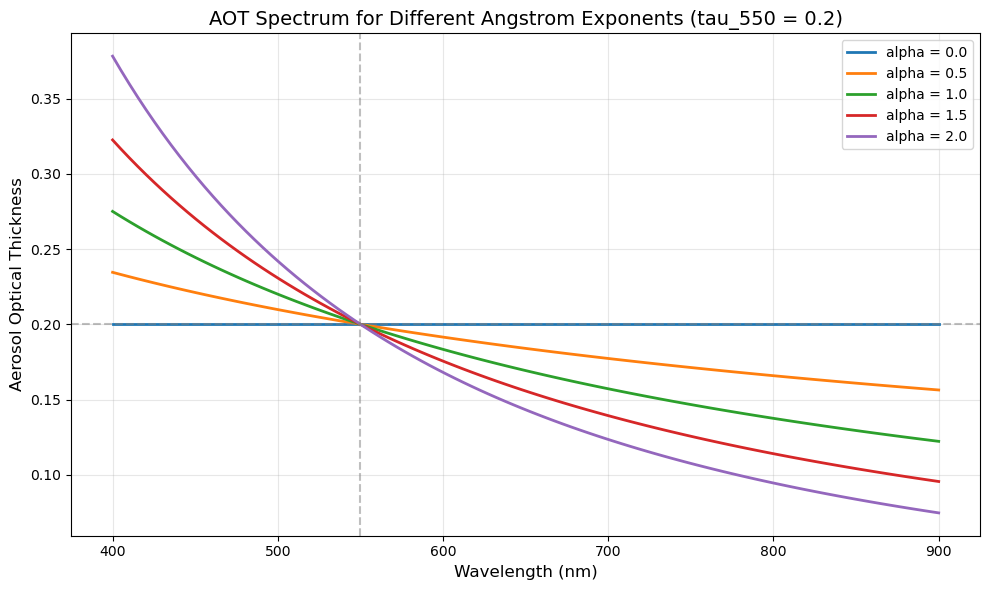

In [44]:
# Visualize AOT spectra for different Angstrom exponents
wavelengths = np.linspace(400, 900, 100)
ref_wavelength = 550  # nm
ref_aot = 0.2

angstrom_values = [0.0, 0.5, 1.0, 1.5, 2.0]

plt.figure(figsize=(10, 6))
for alpha in angstrom_values:
    aot_spectrum = np.array([aerosols.aerosol_optical_thickness(wl, ref_aot, ref_wavelength, alpha) 
                             for wl in wavelengths])
    plt.plot(wavelengths, aot_spectrum, linewidth=2, label=f'alpha = {alpha}')

plt.axhline(ref_aot, color='gray', linestyle='--', alpha=0.5)
plt.axvline(ref_wavelength, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('Aerosol Optical Thickness', fontsize=12)
plt.title(f'AOT Spectrum for Different Angstrom Exponents (tau_550 = {ref_aot})', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 2. The Black Pixel Algorithm

The standard approach for aerosol correction assumes that water-leaving radiance is negligible ("black") in the near-infrared (NIR) bands. This allows the aerosol contribution to be isolated in the NIR and extrapolated to visible wavelengths.

### NIR Black Pixel Assumption

For clear oceanic waters:
- Water strongly absorbs NIR light
- At 765nm and 865nm, water-leaving radiance $\approx$ 0
- Any signal in NIR bands is atmospheric (Rayleigh + aerosols)

In [45]:
# Black pixel correction concept
# After Rayleigh correction, remaining signal in NIR is attributed to aerosols

# Example: Simulated reflectances after Rayleigh correction
rho_rc_765 = 0.008  # Rayleigh-corrected reflectance at 765nm
rho_rc_865 = 0.005  # Rayleigh-corrected reflectance at 865nm

# Under black-pixel assumption:
rho_a_765 = rho_rc_765  # All NIR signal is aerosol
rho_a_865 = rho_rc_865

print("Black Pixel Algorithm:")
print(f"  Rayleigh-corrected at 765nm: {rho_rc_765:.4f}")
print(f"  Rayleigh-corrected at 865nm: {rho_rc_865:.4f}")
print(f"  Aerosol reflectance at 765nm: {rho_a_765:.4f}")
print(f"  Aerosol reflectance at 865nm: {rho_a_865:.4f}")

Black Pixel Algorithm:
  Rayleigh-corrected at 765nm: 0.0080
  Rayleigh-corrected at 865nm: 0.0050
  Aerosol reflectance at 765nm: 0.0080
  Aerosol reflectance at 865nm: 0.0050


### Epsilon Ratio for Model Selection

The ratio of aerosol reflectances at two NIR wavelengths (epsilon) is used to select the appropriate aerosol model:

$$\epsilon = \frac{\rho_a(\lambda_1)}{\rho_a(\lambda_2)}$$

In [46]:
# Epsilon ratio calculation
epsilon = aerosols.epsilon_ratio(rho_a_765, rho_a_865)
print(f"Epsilon ratio (765/865): {epsilon:.3f}")

# The epsilon value helps identify the aerosol type
# Higher epsilon -> larger spectral dependence -> smaller particles

Epsilon ratio (765/865): 1.600


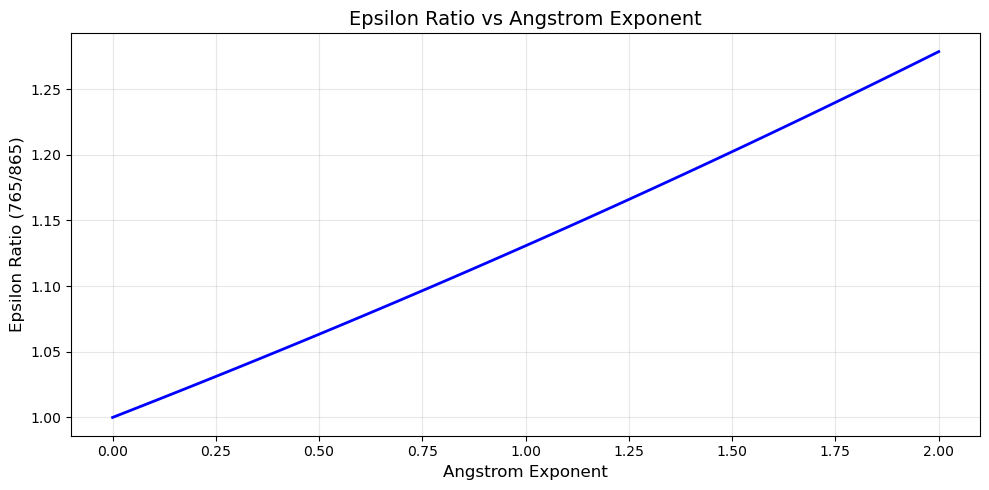

In [47]:
# Epsilon ratio for different aerosol types
angstrom_values = np.linspace(0, 2, 50)
ref_aot = 0.1

epsilon_values = []
for alpha in angstrom_values:
    tau_765 = aerosols.aerosol_optical_thickness(765, ref_aot, 550, alpha)
    tau_865 = aerosols.aerosol_optical_thickness(865, ref_aot, 550, alpha)
    # Simplified: assuming epsilon roughly follows tau ratio
    epsilon_values.append(tau_765 / tau_865)

plt.figure(figsize=(10, 5))
plt.plot(angstrom_values, epsilon_values, 'b-', linewidth=2)
plt.xlabel('Angstrom Exponent', fontsize=12)
plt.ylabel('Epsilon Ratio (765/865)', fontsize=12)
plt.title('Epsilon Ratio vs Angstrom Exponent', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 3. Non-Black Pixel Correction

In turbid or highly productive waters, the NIR water-leaving radiance is **not** zero. An iterative correction is needed.

In [48]:
# Check if non-black pixel correction is needed
# Based on chlorophyll concentration estimate

chlorophyll_values = np.array([0.1, 0.5, 1.0, 5.0, 10.0])  # mg/m^3

print("Non-Black Pixel Assessment:")
print("-" * 50)
for chl in chlorophyll_values:
    needs_correction, weight = aerosols.should_apply_nonblack_pixel(chl)
    if needs_correction:
        status = f"YES - iterative (weight={weight:.2f})"
    else:
        status = "NO - black pixel OK"
    print(f"  Chl = {chl:5.1f} mg/m^3: {status}")

Non-Black Pixel Assessment:
--------------------------------------------------
  Chl =   0.1 mg/m^3: NO - black pixel OK
  Chl =   0.5 mg/m^3: YES - iterative (weight=0.50)
  Chl =   1.0 mg/m^3: YES - iterative (weight=1.00)
  Chl =   5.0 mg/m^3: YES - iterative (weight=1.00)
  Chl =  10.0 mg/m^3: YES - iterative (weight=1.00)


### NIR Water-Leaving Radiance Estimation

For the iterative algorithm, NIR Rrs is estimated from visible-band relationships.

In [49]:
# Estimate NIR Rrs from visible bands
# Using empirical bio-optical relationships

rrs_443 = 0.003  # sr^-1, typical blue reflectance
rrs_555 = 0.004  # sr^-1, typical green reflectance
rrs_670 = 0.005  # sr^-1, typical value for moderately productive water

rrs_nir = aerosols.estimate_nir_rrs(rrs_443, rrs_555, rrs_670, nir_wavelength=765)
print(f"Estimated NIR Rrs from visible bands:")
print(f"  Rrs(443) = {rrs_443:.5f} sr^-1")
print(f"  Rrs(555) = {rrs_555:.5f} sr^-1")
print(f"  Rrs(670) = {rrs_670:.5f} sr^-1")
print(f"  Estimated Rrs(765) = {rrs_nir:.6f} sr^-1")

Estimated NIR Rrs from visible bands:
  Rrs(443) = 0.00300 sr^-1
  Rrs(555) = 0.00400 sr^-1
  Rrs(670) = 0.00500 sr^-1
  Estimated Rrs(765) = 0.000922 sr^-1


---
## 4. Atmospheric Transmittance

Atmospheric transmittance describes the fraction of light that passes through the atmosphere without being absorbed or scattered out of the beam.

### Direct (Beam) Transmittance

Direct transmittance follows Beer's law:

$$t_d(\theta) = \exp\left(-\frac{\tau}{\cos\theta}\right)$$

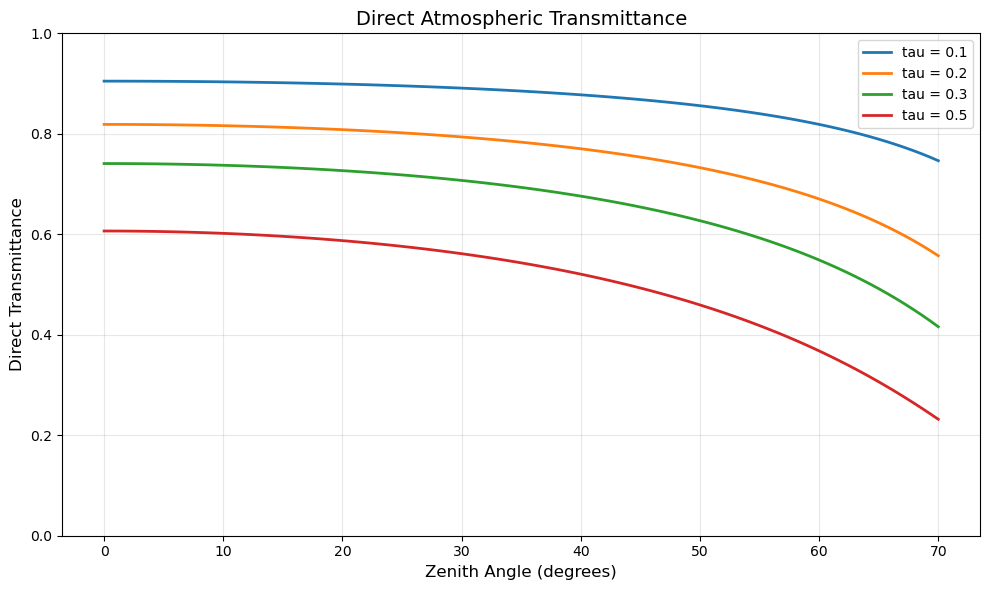

In [50]:
# Direct transmittance vs zenith angle
zenith_angles = np.linspace(0, 70, 100)
optical_thicknesses = [0.1, 0.2, 0.3, 0.5]

plt.figure(figsize=(10, 6))
for tau in optical_thicknesses:
    t_direct = np.array([transmittance.direct_transmittance(z, tau) for z in zenith_angles])
    plt.plot(zenith_angles, t_direct, linewidth=2, label=f'tau = {tau}')

plt.xlabel('Zenith Angle (degrees)', fontsize=12)
plt.ylabel('Direct Transmittance', fontsize=12)
plt.title('Direct Atmospheric Transmittance', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

### Two-Path Transmittance

For ocean color, light travels through the atmosphere twice: once from sun to surface, and again from surface to sensor.

In [51]:
# Two-path direct transmittance
solar_zenith = 30.0
view_zenith = 15.0
optical_thickness = 0.2

t_two_path = transmittance.two_path_direct_transmittance(
    solar_zenith, view_zenith, optical_thickness
)

# Compare to single-path
t_sun = transmittance.direct_transmittance(solar_zenith, optical_thickness)
t_view = transmittance.direct_transmittance(view_zenith, optical_thickness)

print("Two-Path Transmittance:")
print(f"  Solar zenith: {solar_zenith} deg")
print(f"  View zenith: {view_zenith} deg")
print(f"  Optical thickness: {optical_thickness}")
print(f"  Sun path transmittance: {t_sun:.4f}")
print(f"  View path transmittance: {t_view:.4f}")
print(f"  Two-path transmittance: {t_two_path:.4f}")
print(f"  Product t_sun * t_view: {t_sun * t_view:.4f}")

Two-Path Transmittance:
  Solar zenith: 30.0 deg
  View zenith: 15.0 deg
  Optical thickness: 0.2
  Sun path transmittance: 0.7938
  View path transmittance: 0.8130
  Two-path transmittance: 0.6453
  Product t_sun * t_view: 0.6453


### Diffuse Transmittance

For Rayleigh scattering, some light is scattered but still reaches the sensor. The diffuse transmittance accounts for this.

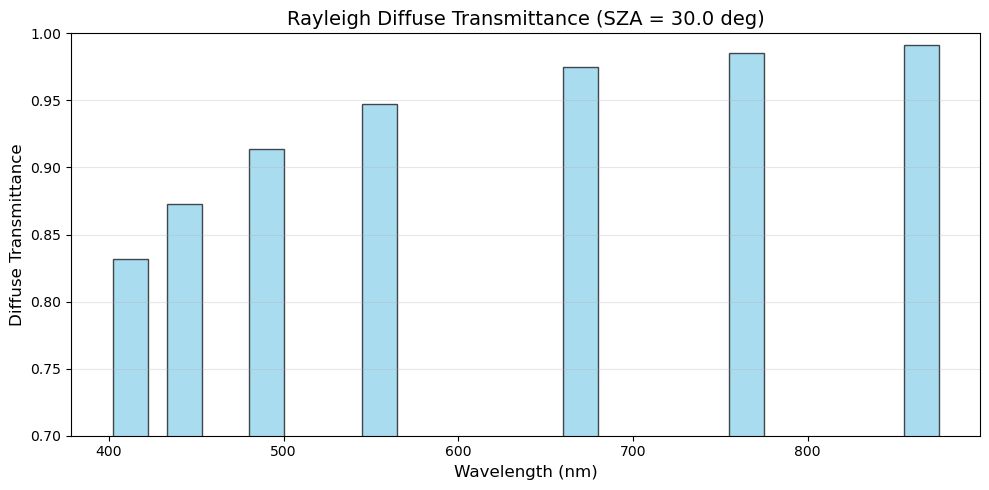

In [52]:
# Rayleigh diffuse transmittance
wavelengths = np.array([412, 443, 490, 555, 670, 765, 865])
solar_zenith = 30.0

t_diffuse = np.array([transmittance.diffuse_transmittance_rayleigh(solar_zenith, wl, constants.STANDARD_PRESSURE) 
                      for wl in wavelengths])

plt.figure(figsize=(10, 5))
plt.bar(wavelengths, t_diffuse, width=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('Diffuse Transmittance', fontsize=12)
plt.title(f'Rayleigh Diffuse Transmittance (SZA = {solar_zenith} deg)', fontsize=14)
plt.ylim(0.7, 1.0)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### Aerosol Diffuse Transmittance

The diffuse transmittance for aerosols is parameterized as:

$$t^*(\theta) = A(\theta) \exp[-B(\theta) \tau_a]$$

where A and B are coefficients that depend on the aerosol model and viewing geometry.

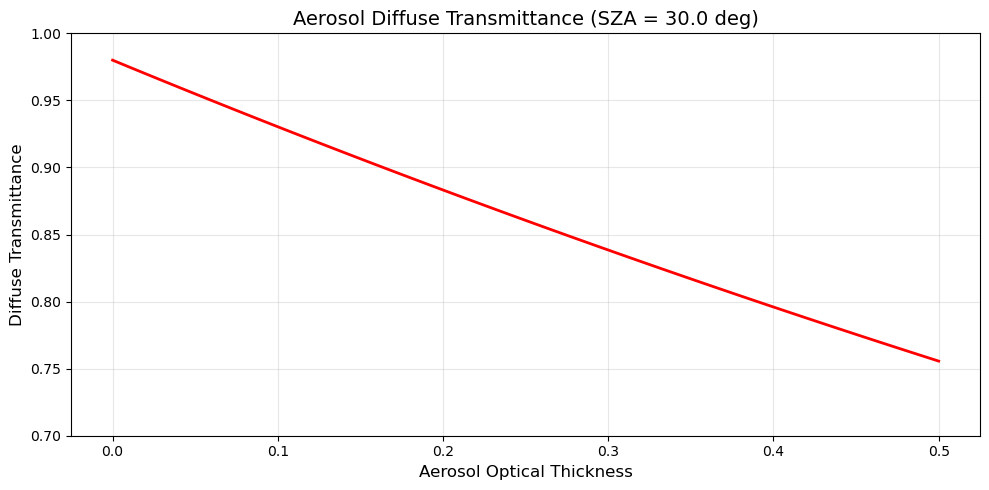

In [53]:
# Aerosol diffuse transmittance
solar_zenith = 30.0
aot_values = np.linspace(0, 0.5, 50)

# Get coefficients for a typical aerosol model
coeffs = transmittance.diffuse_transmittance_coefficients(aerosol_model='maritime')
A = np.interp(solar_zenith, coeffs['theta'], coeffs['A'])
B = np.interp(solar_zenith, coeffs['theta'], coeffs['B'])

t_aerosol = A * np.exp(-B * aot_values)

plt.figure(figsize=(10, 5))
plt.plot(aot_values, t_aerosol, 'r-', linewidth=2)
plt.xlabel('Aerosol Optical Thickness', fontsize=12)
plt.ylabel('Diffuse Transmittance', fontsize=12)
plt.title(f'Aerosol Diffuse Transmittance (SZA = {solar_zenith} deg)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.ylim(0.7, 1.0)
plt.tight_layout()
plt.show()

### Total Transmittance

The total atmospheric transmittance combines contributions from gases, Rayleigh scattering, and aerosols.

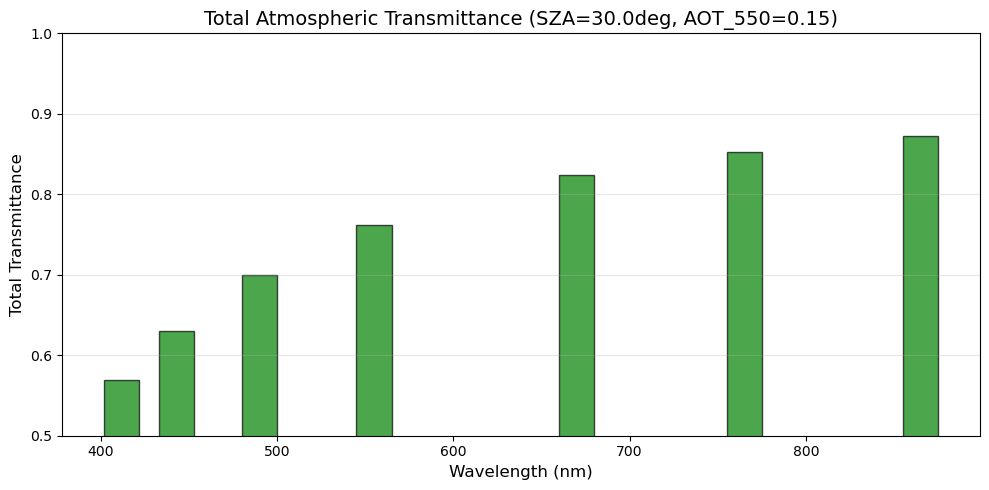

In [54]:
# Total transmittance at each wavelength
wavelengths = np.array([412, 443, 490, 555, 670, 765, 865])
solar_zenith = 30.0
view_zenith = 15.0

# Aerosol optical thickness (assuming typical maritime conditions)
aot_550 = 0.15
angstrom = 0.8
tau_a = np.array([aerosols.aerosol_optical_thickness(wl, aot_550, 550, angstrom) 
                  for wl in wavelengths])

# Total transmittance
t_total = np.array([transmittance.total_transmittance(
    solar_zenith, view_zenith, wl, ta
) for wl, ta in zip(wavelengths, tau_a)])

plt.figure(figsize=(10, 5))
plt.bar(wavelengths, t_total, width=20, color='green', edgecolor='black', alpha=0.7)
plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('Total Transmittance', fontsize=12)
plt.title(f'Total Atmospheric Transmittance (SZA={solar_zenith}deg, AOT_550={aot_550})', fontsize=14)
plt.ylim(0.5, 1.0)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

---
## 5. Effect of Aerosol Loading on Atmospheric Correction

Let's visualize how different aerosol conditions affect the atmospheric signal.

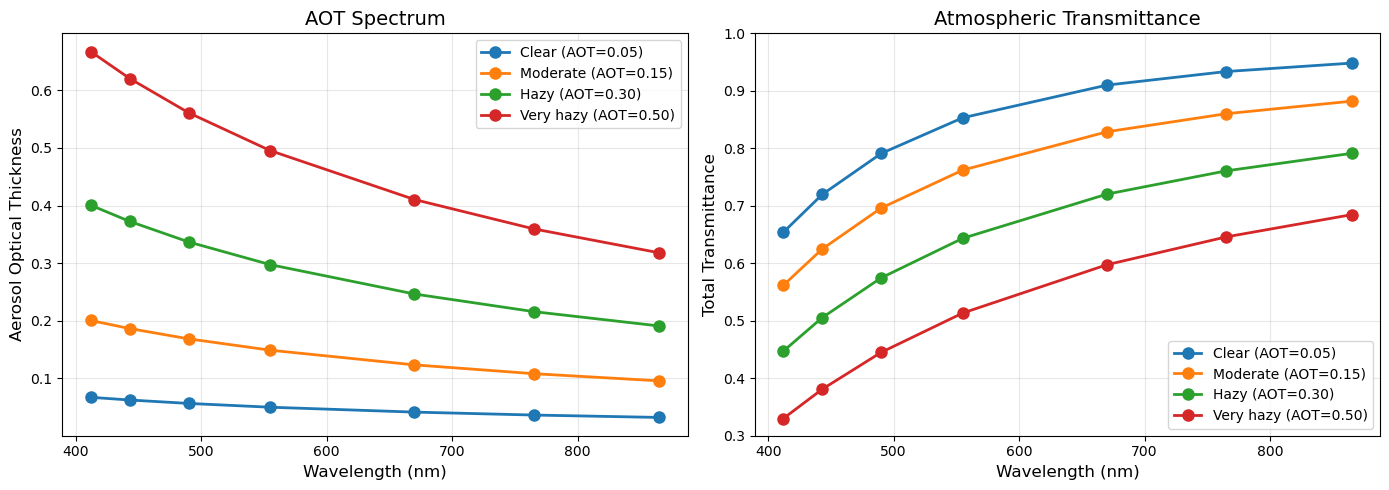

In [55]:
# Compare clear, moderate, and hazy conditions
wavelengths = np.array([412, 443, 490, 555, 670, 765, 865])
aot_conditions = {
    'Clear (AOT=0.05)': 0.05,
    'Moderate (AOT=0.15)': 0.15,
    'Hazy (AOT=0.30)': 0.30,
    'Very hazy (AOT=0.50)': 0.50
}
angstrom = 1.0

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: AOT spectrum
ax1 = axes[0]
for label, aot_550 in aot_conditions.items():
    tau_a = np.array([aerosols.aerosol_optical_thickness(wl, aot_550, 550, angstrom) 
                      for wl in wavelengths])
    ax1.plot(wavelengths, tau_a, 'o-', linewidth=2, markersize=8, label=label)

ax1.set_xlabel('Wavelength (nm)', fontsize=12)
ax1.set_ylabel('Aerosol Optical Thickness', fontsize=12)
ax1.set_title('AOT Spectrum', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Panel 2: Transmittance
ax2 = axes[1]
solar_zenith, view_zenith = 30.0, 15.0

for label, aot_550 in aot_conditions.items():
    tau_a = np.array([aerosols.aerosol_optical_thickness(wl, aot_550, 550, angstrom) 
                      for wl in wavelengths])
    t_total = np.array([transmittance.total_transmittance(
        solar_zenith, view_zenith, wl, ta
    ) for wl, ta in zip(wavelengths, tau_a)])
    ax2.plot(wavelengths, t_total, 'o-', linewidth=2, markersize=8, label=label)

ax2.set_xlabel('Wavelength (nm)', fontsize=12)
ax2.set_ylabel('Total Transmittance', fontsize=12)
ax2.set_title('Atmospheric Transmittance', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0.3, 1.0)

plt.tight_layout()
plt.show()

---
## 6. Geometry Effects

Both solar and viewing geometry significantly affect the atmospheric path length and thus the corrections needed.

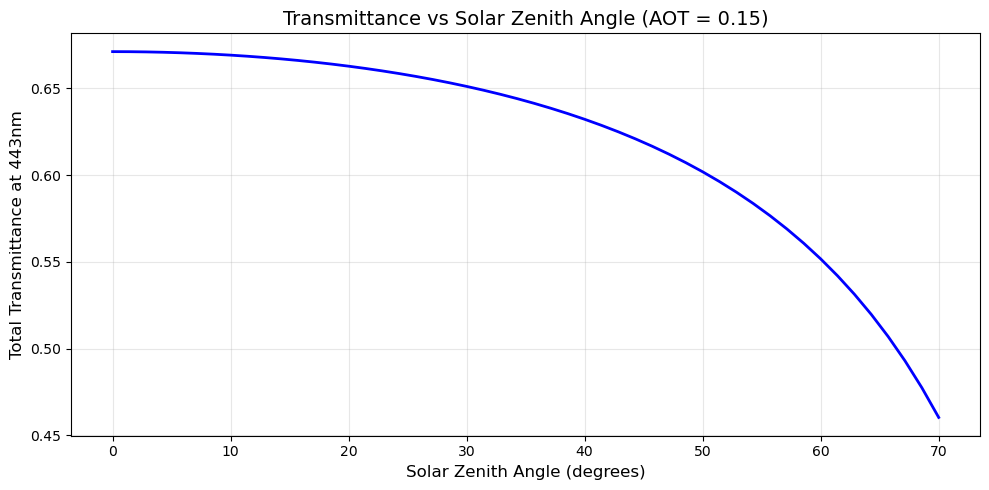

In [56]:
# Effect of solar zenith angle on transmittance
wavelength = 443  # nm
solar_zeniths = np.linspace(0, 70, 50)
view_zenith = 15.0

tau_a = 0.15  # aerosol optical thickness at this wavelength

t_vs_sza = np.array([transmittance.total_transmittance(
    sz, view_zenith, wavelength, tau_a
) for sz in solar_zeniths])

plt.figure(figsize=(10, 5))
plt.plot(solar_zeniths, t_vs_sza, 'b-', linewidth=2)
plt.xlabel('Solar Zenith Angle (degrees)', fontsize=12)
plt.ylabel(f'Total Transmittance at {wavelength}nm', fontsize=12)
plt.title(f'Transmittance vs Solar Zenith Angle (AOT = {tau_a})', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## Key Takeaways

1. **Aerosol models** characterize different particle types through Angstrom exponent and single scatter albedo

2. **Black pixel algorithm** assumes zero NIR water signal to isolate aerosols - works for clear oceanic waters

3. **Non-black pixel correction** is needed for turbid/productive waters with significant NIR water signal

4. **Epsilon ratio** (NIR band ratio) helps select the appropriate aerosol model

5. **Transmittance** decreases with:
   - Higher optical thickness (more aerosols/Rayleigh)
   - Larger zenith angles (longer path)
   - Shorter wavelengths (more Rayleigh scattering)

6. **Two-path transmittance** accounts for attenuation both sun-to-surface and surface-to-sensor